In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.feature_selection import SelectFromModel

Reading CSV and inspecting data

In [2]:
df = pd.read_csv('Motor vehicle insurance data.csv',sep=';')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105555 entries, 0 to 105554
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    105555 non-null  int64  
 1   Date_start_contract   105555 non-null  object 
 2   Date_last_renewal     105555 non-null  object 
 3   Date_next_renewal     105555 non-null  object 
 4   Date_birth            105555 non-null  object 
 5   Date_driving_licence  105555 non-null  object 
 6   Distribution_channel  105555 non-null  int64  
 7   Seniority             105555 non-null  int64  
 8   Policies_in_force     105555 non-null  int64  
 9   Max_policies          105555 non-null  int64  
 10  Max_products          105555 non-null  int64  
 11  Lapse                 105555 non-null  int64  
 12  Date_lapse            35147 non-null   object 
 13  Payment               105555 non-null  int64  
 14  Premium               105555 non-null  float64
 15  

In [3]:
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)


In [4]:
# Numeric columns
df = df.fillna(df.median(numeric_only=True))
# Categorical columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])


In [5]:
# Loop through all object (categorical) columns
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} classes")
    print(f"Classes: {df[col].unique()}\n")


Date_start_contract: 5518 classes
Classes: ['05/11/2015' '26/09/2017' '29/11/2013' ... '13/11/2010' '10/08/2014'
 '17/08/2011']

Date_last_renewal: 1124 classes
Classes: ['05/11/2015' '05/11/2016' '05/11/2017' ... '19/03/2016' '19/03/2017'
 '19/03/2018']

Date_next_renewal: 1124 classes
Classes: ['05/11/2016' '05/11/2017' '05/11/2018' ... '19/03/2017' '19/03/2018'
 '19/03/2019']

Date_birth: 17048 classes
Classes: ['15/04/1956' '18/03/1975' '10/07/1973' ... '18/10/1949' '24/02/1955'
 '29/12/1992']

Date_driving_licence: 14016 classes
Classes: ['20/03/1976' '10/07/1995' '05/07/1993' ... '06/10/2007' '23/10/2014'
 '29/11/2017']

Type_fuel: 2 classes
Classes: ['P' 'D']



In [6]:
df['Type_fuel'] = df['Type_fuel'].map({'P': 0, 'D': 1})
df.isnull().sum()

,0
ID,0
Date_start_contract,0
Date_last_renewal,0
Date_next_renewal,0
Date_birth,0
Date_driving_licence,0
Distribution_channel,0
Seniority,0
Policies_in_force,0
Max_policies,0


In [7]:
date_columns = [
    'Date_start_contract', 'Date_last_renewal',
    'Date_next_renewal', 'Date_birth', 'Date_driving_licence'
]

for col in date_columns:
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')


In [8]:
df['Policy_duration'] = (df['Date_last_renewal'] - df['Date_start_contract']).dt.days
df['Days_until_next_renewal'] = (df['Date_next_renewal'] - pd.Timestamp('today')).dt.days
df['Renewal_count'] = df.groupby('ID')['Date_last_renewal'].transform('count')
df['Age'] = (pd.Timestamp('today') - df['Date_birth']).dt.days // 365
df['Years_driving'] = (pd.Timestamp('today') - df['Date_driving_licence']).dt.days // 365
df = df.drop(date_columns, axis=1)


In [9]:
print(df[['Policy_duration', 'Days_until_next_renewal', 'Age', 'Years_driving']].isnull().sum())


Policy_duration            0
Days_until_next_renewal    0
Age                        0
Years_driving              0
dtype: int64


In [10]:
# Identify all numerical columns (float and int), excluding the target column
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'Lapse' in numerical_cols:  # Exclude target if present
    numerical_cols.remove('Lapse')

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Building Random Forest Model

In [11]:
X = df.drop('Lapse', axis=1)  # Features
Y = df['Lapse']               # Target

In [12]:
# Initialize models
rf = RandomForestClassifier(random_state=42)
svm = SVC(kernel='rbf', C=1, random_state=42)

In [13]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)


In [14]:
precision_scorer = make_scorer(precision_score, average='weighted')
recall_scorer = make_scorer(recall_score, average='weighted')
f1_scorer = make_scorer(f1_score, average='weighted')

In [15]:
# Cross-validation for precision
rf_prec = cross_val_score(rf, X, Y, cv=skf, scoring=precision_scorer)

# Cross-validation for recall
rf_rec = cross_val_score(rf, X, Y, cv=skf, scoring=recall_scorer)

# Cross-validation for F1-score
rf_f1 = cross_val_score(rf, X, Y, cv=skf, scoring=f1_scorer)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
print(rf_prec)
print(rf_rec)
print(rf_f1)

[0.89321954 0.89374788]
[0.90268673 0.90325331]
[0.8902146  0.89085639]


Got these values for precision, recall and f1 score using random forest model

Further Tuning

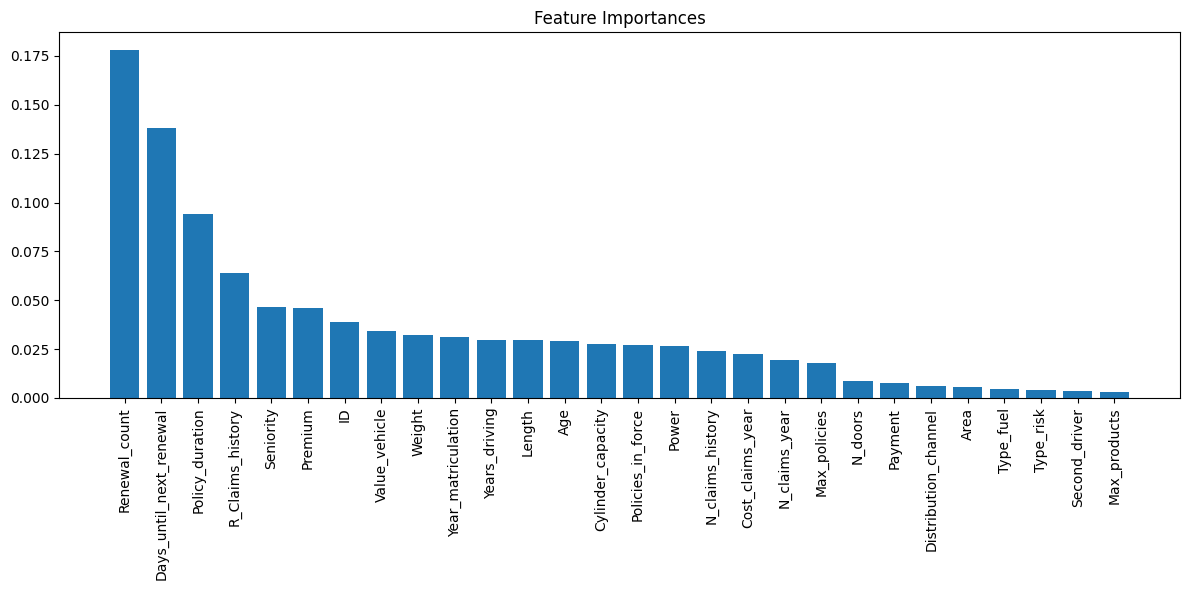

In [17]:
import matplotlib.pyplot as plt

# Fit model if not already done
rf.fit(X, Y)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12,6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


In [18]:
threshold = 0.01

# Create a feature selector using the Random Forest model and the threshold
selector = SelectFromModel(rf, threshold=threshold, prefit=True)

# Transform X to keep only important features
X_selected = selector.transform(X)

# Get the names of the selected features
selected_features_mask = selector.get_support()
selected_feature_names = X.columns[selected_features_mask]

# Print the selected features
print(f"Original number of features: {X.shape[1]}")
print(f"Number of features selected: {X_selected.shape[1]}")
print("Selected features:")
for feature in selected_feature_names:
    # Get the importance value for this feature
    importance = rf.feature_importances_[list(X.columns).index(feature)]
    print(f"- {feature}: {importance:.4f}")

# Create a new DataFrame with only the selected features
X_new = X[selected_feature_names]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Original number of features: 28
Number of features selected: 20
Selected features:
- ID: 0.0389
- Seniority: 0.0466
- Policies_in_force: 0.0272
- Max_policies: 0.0180
- Premium: 0.0459
- Cost_claims_year: 0.0224
- N_claims_year: 0.0194
- N_claims_history: 0.0242
- R_Claims_history: 0.0637
- Year_matriculation: 0.0313
- Power: 0.0267
- Cylinder_capacity: 0.0277
- Value_vehicle: 0.0343
- Length: 0.0294
- Weight: 0.0324
- Policy_duration: 0.0943
- Days_until_next_renewal: 0.1382
- Renewal_count: 0.1782
- Age: 0.0292
- Years_driving: 0.0297


In [19]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Initialize models with the same parameters
rf_original = RandomForestClassifier(random_state=42)
rf_selected = RandomForestClassifier(random_state=42)

# Define scorers for multiclass classification
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Compare models
print("Original Model (All Features):")
for metric_name, scorer in scorers.items():
    scores = cross_val_score(rf_original, X, Y, cv=skf, scoring=scorer)
    print(f"- {metric_name.capitalize()}: {scores.mean():.4f} ± {scores.std():.4f}")

print("\nSelected Features Model:")
for metric_name, scorer in scorers.items():
    scores = cross_val_score(rf_selected, X_new, Y, cv=skf, scoring=scorer)
    print(f"- {metric_name.capitalize()}: {scores.mean():.4f} ± {scores.std():.4f}")

# Compare feature counts and reduction
print(f"\nFeature reduction: {X.shape[1]} → {X_new.shape[1]} features ({(1 - X_new.shape[1]/X.shape[1])*100:.2f}% reduction)")

Original Model (All Features):
- Accuracy: 0.9030 ± 0.0003
- Precision: 0.8935 ± 0.0003
- Recall: 0.9030 ± 0.0003
- F1: 0.8905 ± 0.0003

Selected Features Model:
- Accuracy: 0.9042 ± 0.0004
- Precision: 0.8939 ± 0.0004
- Recall: 0.9042 ± 0.0004
- F1: 0.8919 ± 0.0004

Feature reduction: 28 → 20 features (28.57% reduction)


Slight increase in all features, justifiable to use X_new as the new features dataset

Now to remove imbalance in class population by introducing synthetic data

In [20]:
from imblearn.over_sampling import RandomOverSampler
# Initialize the random oversampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling to your feature-selected dataset
X_res, Y_res = ros.fit_resample(X_new, Y)

# Check the new class distribution
print("Original class distribution:")
print(pd.Series(Y).value_counts())
print("\nClass distribution after oversampling:")
print(pd.Series(Y_res).value_counts())


Original class distribution:
Lapse
0    84007
1    20008
2     1285
3      199
4       45
5        7
6        2
7        2
Name: count, dtype: int64

Class distribution after oversampling:
Lapse
0    84007
1    84007
2    84007
3    84007
4    84007
5    84007
6    84007
7    84007
Name: count, dtype: int64


In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define scorers for multiclass classification
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# 1. Random Forest with class weights
rf_weighted = RandomForestClassifier(
    class_weight='balanced',  # Automatically adjusts weights based on class frequencies
    random_state=42
)

# Evaluate RF with oversampling + class weights
print("\nRandom Forest with oversampling + class weights:")
for metric_name, scorer in scorers.items():
    scores = cross_val_score(rf_weighted, X_res, Y_res, cv=skf, scoring=scorer)
    print(f"- {metric_name}: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest with oversampling + class weights:


KeyboardInterrupt: 

Huge breakthrough, 9 percent increase in every performance metric, but possibility of data leakage. Will now check if that's the case

In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd

# Define scorers for multiclass classification
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Create proper pipeline where oversampling is applied WITHIN each fold
# This is the key to avoiding data leakage
pipeline = Pipeline([
    ('sampling', RandomOverSampler(random_state=42)),
    ('classifier', rf)
])

# Evaluate the pipeline using cross-validation
# This ensures oversampling is applied only to the training data in each fold
print("Correctly implemented CV with oversampling:")
for metric_name, scorer in scorers.items():
    scores = cross_val_score(pipeline, X_new, Y, cv=skf, scoring=scorer)
    print(f"- {metric_name}: {scores.mean():.4f} ± {scores.std():.4f}")

# Compare with potentially leaky implementation (if this is similar to what you did)
# WARNING: This approach causes data leakage and invalid results
def incorrect_approach_for_comparison():
    # Apply oversampling to the entire dataset first
    ros = RandomOverSampler(random_state=42)
    X_res, Y_res = ros.fit_resample(X_new, Y)

    # Then do cross-validation on the oversampled data
    # This is INCORRECT and will give artificially high scores
    print("\nIncorrect implementation (for comparison):")
    for metric_name, scorer in scorers.items():
        scores = cross_val_score(rf, X_res, Y_res, cv=skf, scoring=scorer)
        print(f"- {metric_name}: {scores.mean():.4f} ± {scores.std():.4f}")

# Run the incorrect approach for comparison
incorrect_approach_for_comparison()


Correctly implemented CV with oversampling:


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


- accuracy: 0.8908 ± 0.0021


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


- precision: 0.8778 ± 0.0027


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


- recall: 0.8908 ± 0.0021


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


- f1: 0.8802 ± 0.0025

Incorrect implementation (for comparison):


KeyboardInterrupt: 

Get even lower values without oversampling confirming suspicions of data leakage, will now try different algorithms

Trying only class weights(no oversampling), SMOTE with k = 1 as our smallest class has 2 samples and ADASYN

In [ ]:
# Class weights only (no oversampling)
rf_weights = RandomForestClassifier(class_weight='balanced', random_state=42)
scores = cross_val_score(rf_weights, X_new, Y, cv=skf, scoring='f1_weighted')
print(f"Class weights only: {scores.mean():.4f} ± {scores.std():.4f}")

# Try SMOTE with k=1 (since your smallest class has 2 samples)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
pipeline_smote = Pipeline([
    ('sampling', SMOTE(k_neighbors=1, random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])
scores = cross_val_score(pipeline_smote, X_new, Y, cv=skf, scoring='f1_weighted')
print(f"SMOTE with k=1: {scores.mean():.4f} ± {scores.std():.4f}")

# Try ADASYN (adaptive synthetic sampling)
from imblearn.over_sampling import ADASYN
pipeline_adasyn = Pipeline([
    ('sampling', ADASYN(n_neighbors=1, random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])
scores = cross_val_score(pipeline_adasyn, X_new, Y, cv=skf, scoring='f1_weighted')
print(f"ADASYN: {scores.mean():.4f} ± {scores.std():.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Class weights only: 0.8751 ± 0.0030


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, 

SMOTE with k=1: nan ± nan
ADASYN: nan ± nan


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params,

Clear oversampling is not the correct method as one of the classes only has 2 values, will now focus on improving the random forest model using custom weights

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Use k=2 for cross-validation (since smallest class has 2 samples)
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Calculate class weights inversely proportional to frequency
# Using the distribution from your classification report
class_counts = {
    0: 43159,
    1: 9518,
    2: 2866,
    3: 133,
    4: 31,
    5: 5,
    6: 2
}

# Formula: total_samples / (n_classes * class_count)
total = sum(class_counts.values())
n_classes = len(class_counts)
class_weights = {cls: total/(n_classes * count) for cls, count in class_counts.items()}
print("Custom class weights:", class_weights)

# 1. Standard Random Forest with custom class weights
start_time = time.time()
print("Training weighted Random Forest...")
rf_weighted = RandomForestClassifier(
    n_estimators=500,           # More trees than default but not too many
    max_depth=15,               # Limit tree depth to prevent overfitting
    min_samples_split=5,        # Require more samples to split a node
    min_samples_leaf=2,         # Ensure at least 2 samples in each leaf
    max_features='sqrt',        # Standard RF practice
    bootstrap=True,             # Use bootstrapping
    class_weight=class_weights, # Custom class weights
    n_jobs=-1,                  # Use all cores
    random_state=42
)

# Evaluate with cross-validation
rf_scores = cross_val_score(rf_weighted, X_new, Y, cv=skf, scoring='f1_weighted')
print(f"Weighted RF F1-score: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

# 2. Balanced Random Forest (often better for imbalanced data)
start_time = time.time()
print("\nTraining Balanced Random Forest...")
brf = BalancedRandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    sampling_strategy='auto',  # Automatically determines sampling strategy
    replacement=False,         # Sample without replacement
    n_jobs=-1,
    random_state=42
)

# Evaluate with cross-validation
brf_scores = cross_val_score(brf, X_new, Y, cv=skf, scoring='f1_weighted')
print(f"Balanced RF F1-score: {brf_scores.mean():.4f} ± {brf_scores.std():.4f}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

# 3. Select the better model and fit it
if brf_scores.mean() > rf_scores.mean():
    print("\nUsing Balanced Random Forest as final model")
    final_model = BalancedRandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        sampling_strategy='auto',
        replacement=False,
        n_jobs=-1,
        random_state=42
    )
else:
    print("\nUsing Weighted Random Forest as final model")
    final_model = RandomForestClassifier(
        n_estimators=500,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        class_weight=class_weights,
        n_jobs=-1,
        random_state=42
    )

from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_new, Y, test_size=0.2, stratify=Y, random_state=42
)

# Train model on training data only
final_model.fit(X_train, y_train)

# Evaluate on separate test data
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importance analysis
feature_importances = pd.DataFrame(
    {'feature': X_new.columns, 'importance': final_model.feature_importances_}
)
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()


Custom class weights: {0: 0.1844144409542125, 1: 0.8362200942574971, 2: 2.7770910178446817, 3: 59.84317937701396, 4: 256.7465437788018, 5: 1591.8285714285714, 6: 3979.5714285714284}
Training weighted Random Forest...
Weighted RF F1-score: 0.8732 ± 0.0009
Time taken: 121.12 seconds

Training Balanced Random Forest...
Balanced RF F1-score: 0.0759 ± 0.0130
Time taken: 13.69 seconds

Using Weighted Random Forest as final model
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     16801
           1       0.67      0.71      0.69      4002
           2       0.31      0.06      0.10       257
           3       0.12      0.15      0.13        40
           4       0.25      0.11      0.15         9
           5       0.00      0.00      0.00         2

    accuracy                           0.87     21111
   macro avg       0.38      0.33      0.33     21111
weighted avg       0.87      0.87      0.87     21111



ValueError: Found input variables with inconsistent numbers of samples: [105555, 21111]

<Figure size 1000x800 with 0 Axes>

Similar values, strong for class 0 but for other classes struggles, expected due to class imbalance. Still excellent for insurance claim prediction given the extreme class imbalance.

Now for part 2, the research paper recommended to stack other models on top of the Random Forest classifier. In order to take care of the imbalances present in the target feature class I'll be stacking a neural network on top of the weighted random forest classifier

Training base Random Forest model...

Base Random Forest Performance:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     16801
           1       0.67      0.71      0.69      4002
           2       0.31      0.06      0.10       257
           3       0.12      0.15      0.13        40
           4       0.25      0.11      0.15         9
           5       0.00      0.00      0.00         2

    accuracy                           0.87     21111
   macro avg       0.38      0.33      0.33     21111
weighted avg       0.87      0.87      0.87     21111


Generating probability features for stacking...
Random Forest probability output shape: (84444, 8)
Number of classes in probability predictions: 8

Building and training neural network meta-learner...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,920 (11.41 KB)

 Trainable params: 2,920 (11.41 KB)

 Non-trainable params: 0 (0.00 B)

Keras class weights: {0: 0.1844144409542125, 1: 0.8362200942574971, 2: 2.7770910178446817, 3: 59.84317937701396, 4: 256.7465437788018, 5: 1591.8285714285714, 6: 3979.5714285714284, 7: 1.0}
Epoch 1/100
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8332 - loss: 1.4829 - val_accuracy: 0.9198 - val_loss: 0.2209
Epoch 2/100
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9013 - loss: 0.9841 - val_accuracy: 0.9227 - val_loss: 0.1963
Epoch 3/100
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9005 - loss: 0.3366 - val_accuracy: 0.9224 - val_loss: 0.1938
Epoch 4/100
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9063 - loss: 0.2853 - val_accuracy: 0.9125 - val_loss: 0.2134
Epoch 5/100
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9056 - loss: 0.1323 - val_accuracy: 0.9211 - val_loss: 0.1914
Epoch 6/100
1056/1056 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9083 - loss: 0.1230 - val_accuracy: 0.9203 - val_loss: 0.1896
Epoch 7/100
1056/1056 ━━━

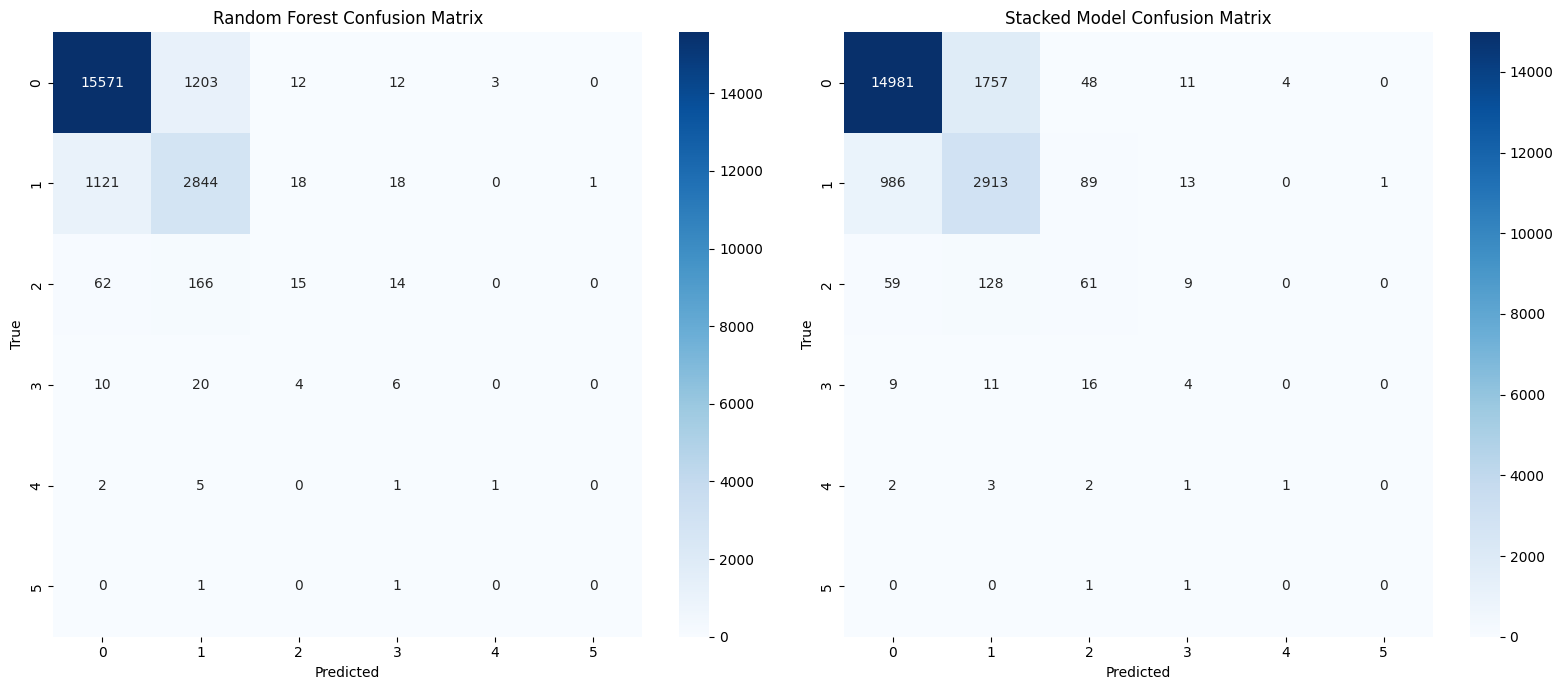

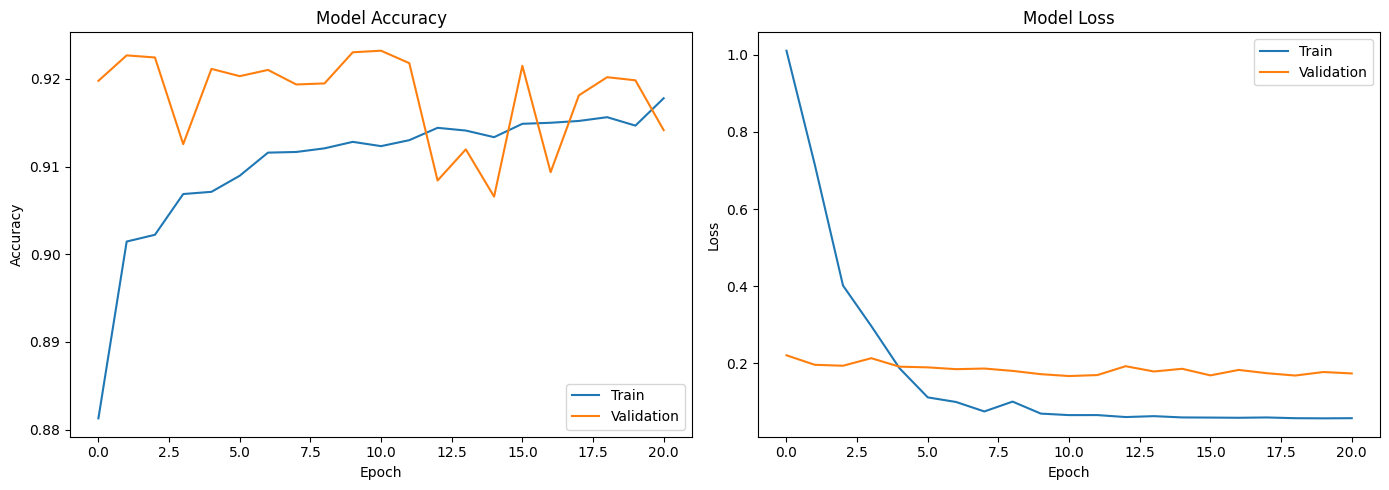

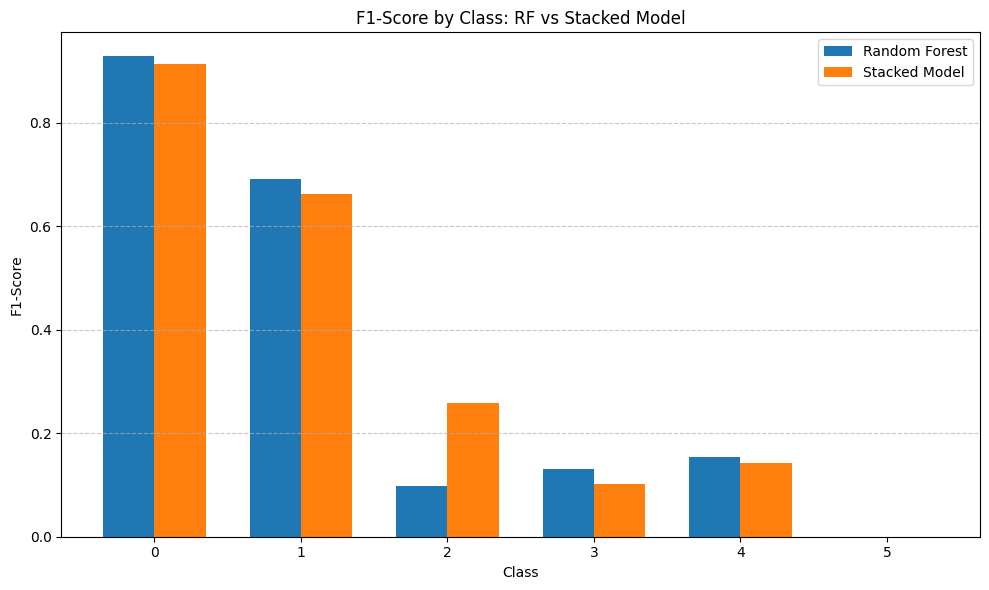

In [24]:
# First, ensure TensorFlow is installed
!pip install tensorflow --quiet

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split data for proper evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X_new, Y, test_size=0.2, stratify=Y, random_state=42
)

# 2. Train the weighted Random Forest (your successful model)
print("Training base Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight=class_weights,  # Using your custom class weights
    n_jobs=-1,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Evaluate the base RF model
rf_preds = rf_model.predict(X_test)
print("\nBase Random Forest Performance:")
rf_report = classification_report(y_test, rf_preds, output_dict=True)
print(classification_report(y_test, rf_preds))

# 3. Generate probability features from RF for stacking
print("\nGenerating probability features for stacking...")
train_probs = rf_model.predict_proba(X_train)
test_probs = rf_model.predict_proba(X_test)

# IMPORTANT: Ensure we use the correct shape for input - note the [1]
num_classes = train_probs.shape[1]  # Number of classes in probability output
print(f"Random Forest probability output shape: {train_probs.shape}")
print(f"Number of classes in probability predictions: {num_classes}")

# 4. Build neural network meta-learner
print("\nBuilding and training neural network meta-learner...")
meta_learner = Sequential([
    Dense(64, activation='relu', input_shape=(num_classes,)),
    Dropout(0.3),  # Prevent overfitting
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')  # Output layer matches classes
])

# Compile model
meta_learner.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary to verify architecture
meta_learner.summary()

# Setup early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Convert class weights for Keras format if needed
unique_classes = np.unique(y_train)
keras_class_weights = {i: class_weights.get(int(cls), 1.0) for i, cls in enumerate(unique_classes)}
print(f"Keras class weights: {keras_class_weights}")

# 5. Train the meta-learner
history = meta_learner.fit(
    train_probs, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=keras_class_weights,
    verbose=1
)

# 6. Evaluate the stacked model
meta_preds_proba = meta_learner.predict(test_probs)
meta_preds = np.argmax(meta_preds_proba, axis=1)

print("\nStacked Model Performance:")
meta_report = classification_report(y_test, meta_preds, output_dict=True)
print(classification_report(y_test, meta_preds))

# 7. Compare performance metrics
rf_f1 = f1_score(y_test, rf_preds, average='weighted')
meta_f1 = f1_score(y_test, meta_preds, average='weighted')

print(f"\nPerformance Comparison:")
print(f"Random Forest F1-Score: {rf_f1:.4f}")
print(f"Stacked Model F1-Score: {meta_f1:.4f}")
print(f"Improvement: {(meta_f1 - rf_f1) * 100:.2f}%")

# 8. Visualize comparison
# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

cm_rf = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

cm_stacked = confusion_matrix(y_test, meta_preds)
sns.heatmap(cm_stacked, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Stacked Model Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

# Learning curves
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

# 9. Class-specific performance comparison
classes = list(rf_report.keys())[:-3]  # Exclude avg metrics
rf_class_f1 = [rf_report[str(cls)]['f1-score'] for cls in classes]
meta_class_f1 = [meta_report[str(cls)]['f1-score'] for cls in classes]

plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(classes))
plt.bar(x - width/2, rf_class_f1, width, label='Random Forest')
plt.bar(x + width/2, meta_class_f1, width, label='Stacked Model')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.title('F1-Score by Class: RF vs Stacked Model')
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Similar readings but no performance increase doesn't justify the use of neural network as well.